In [14]:
# Imports
# Basics
from __future__ import print_function, division
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics.pairwise as smp

from sklearn.decomposition import NMF


# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [34]:
dtypes = {
    'id': np.int32,
    'year': np.int32,
    'month': np.int8,
    'id': 'object',
    'url': 'object',
    'word_count': np.float16,
    'article': 'object'
    ''
}
raw_df = pd.read_csv('./data/11_17_final.csv', names=['ind', 'year', 'month', 'id', 'url', 'word_count', 'article'], dtype=dtypes, index_col=False)

In [35]:
raw_df.drop_duplicates(subset='id', inplace=True)
raw_df = raw_df.dropna().reset_index()

In [17]:
subset_size = 20000
subset_df = raw_df.groupby('year').apply(lambda x: x.sample(subset_size)).reset_index(drop=True)

In [18]:
article_text = subset_df['article']

In [148]:
# Vectorize the text using TFIDF
tfidf = TfidfVectorizer(stop_words="english", 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", #words with >= 2 alpha chars 
                        min_df=10)
tfidf_vecs = tfidf.fit_transform(article_text) # fits keys and weights to tfidf and transforms articles to store in tfidf_vecs
# pd.DataFrame(tfidf_vecs.todense(), 
#              columns=tfidf.get_feature_names()
#             ).head()

In [20]:
# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants 
# terms by docs instead of docs by terms
tfidf_corpus = matutils.Sparse2Corpus(tfidf_vecs.transpose())

# Row indices
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

# This is a hack for Python 3!
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)

2018-03-07 05:50:20,262 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-07 05:50:22,908 : INFO : adding document #10000 to Dictionary(0 unique tokens: [])
2018-03-07 05:50:25,636 : INFO : adding document #20000 to Dictionary(0 unique tokens: [])
2018-03-07 05:50:28,365 : INFO : adding document #30000 to Dictionary(0 unique tokens: [])
2018-03-07 05:50:31,002 : INFO : adding document #40000 to Dictionary(0 unique tokens: [])
2018-03-07 05:50:33,609 : INFO : adding document #50000 to Dictionary(0 unique tokens: [])
2018-03-07 05:50:36,286 : INFO : adding document #60000 to Dictionary(0 unique tokens: [])
2018-03-07 05:50:38,896 : INFO : adding document #70000 to Dictionary(0 unique tokens: [])
2018-03-07 05:50:41,507 : INFO : adding document #80000 to Dictionary(0 unique tokens: [])
2018-03-07 05:50:44,095 : INFO : adding document #90000 to Dictionary(0 unique tokens: [])
2018-03-07 05:50:46,842 : INFO : adding document #100000 to Dictionary(0 unique tokens: [])
20

In [21]:
tfidf_svd_v2 = TruncatedSVD(n_components=150, n_iter=100, random_state=2)
review_reduced_v2 = tfidf_svd_v2.fit_transform(tfidf_vecs)  
# print(tfidf_svd_v2.explained_variance_ratio_) 
# print(tfidf_svd_v2.singular_values_)

Text(0.5,1,'Elbow Plot LSI with 150 reduced features')

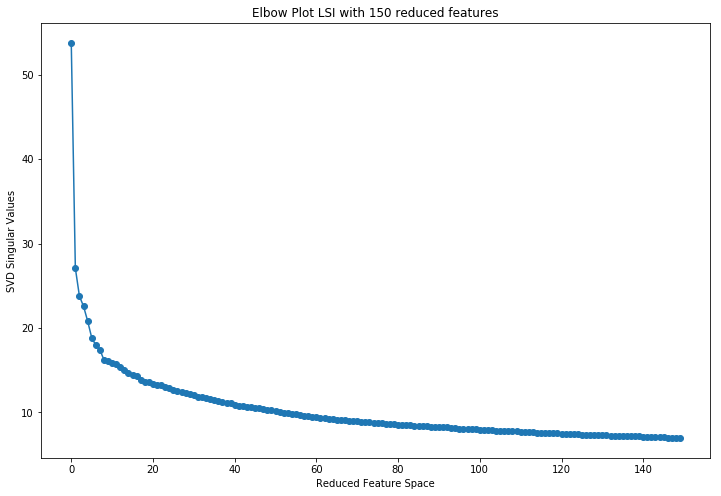

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(range(0,150), list(tfidf_svd_v2.singular_values_), marker='o')
plt.xlabel('Reduced Feature Space')
plt.ylabel('SVD Singular Values')
plt.title('Elbow Plot LSI with 150 reduced features')

In [24]:
# Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics
# num_topics is the number of dimensions to reduce to after the SVD
# Analagous to "fit" in sklearn, it primes an LSI space
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=50)

2018-03-07 06:17:15,896 : INFO : using serial LSI version on this node
2018-03-07 06:17:15,898 : INFO : updating model with new documents
2018-03-07 06:17:17,052 : INFO : preparing a new chunk of documents
2018-03-07 06:17:18,457 : INFO : using 100 extra samples and 2 power iterations
2018-03-07 06:17:18,458 : INFO : 1st phase: constructing (69931, 150) action matrix
2018-03-07 06:17:19,420 : INFO : orthonormalizing (69931, 150) action matrix
2018-03-07 06:17:25,030 : INFO : 2nd phase: running dense svd on (150, 20000) matrix
2018-03-07 06:17:25,435 : INFO : computing the final decomposition
2018-03-07 06:17:25,439 : INFO : keeping 50 factors (discarding 32.672% of energy spectrum)
2018-03-07 06:17:25,538 : INFO : processed documents up to #20000
2018-03-07 06:17:25,556 : INFO : topic #0(23.785): 0.353*"said" + 0.296*"mr" + 0.116*"new" + 0.111*"percent" + 0.101*"ms" + 0.095*"year" + 0.091*"people" + 0.091*"like" + 0.086*"government" + 0.083*"state"
2018-03-07 06:17:25,558 : INFO : topi

2018-03-07 06:18:09,051 : INFO : topic #0(52.445): 0.337*"said" + 0.318*"mr" + 0.118*"new" + 0.110*"ms" + 0.094*"people" + 0.092*"percent" + 0.091*"year" + 0.091*"like" + 0.083*"state" + 0.078*"city"
2018-03-07 06:18:09,056 : INFO : topic #1(26.453): -0.348*"mr" + 0.281*"game" + 0.198*"season" + 0.163*"team" + 0.146*"games" + 0.135*"points" + -0.131*"trump" + 0.114*"players" + 0.112*"scored" + 0.112*"league"
2018-03-07 06:18:09,059 : INFO : topic #2(23.333): 0.412*"percent" + -0.286*"mr" + 0.141*"market" + 0.138*"billion" + 0.132*"bank" + 0.123*"company" + 0.120*"growth" + 0.114*"investors" + 0.113*"economy" + 0.112*"rose"
2018-03-07 06:18:09,060 : INFO : topic #3(21.971): -0.200*"ms" + 0.183*"game" + 0.173*"trump" + 0.133*"obama" + 0.132*"points" + 0.126*"mr" + -0.123*"york" + -0.121*"new" + 0.113*"season" + 0.103*"republican"
2018-03-07 06:18:09,063 : INFO : topic #4(20.271): 0.287*"trump" + 0.247*"mr" + -0.221*"police" + -0.174*"said" + 0.156*"republican" + -0.138*"military" + -0.13

In [240]:
# lsi.show_topics(num_words=15)

In [25]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[tfidf_corpus]

### Vector Similiary Recommendation system (works but unused)

In [ ]:
# Dump the resulting document vectors into a list so we can take a look
# doc_vecs = [doc for doc in lsi_corpus]
# doc_vecs[0]

In [ ]:
# Create an index transformer that calculates similarity based on 
# our space

# index = similarities.MatrixSimilarity(doc_vecs, 
#                                       num_features=50)

In [ ]:
#each doc_vec represents reduced feature matrix (n_documents x r_reduced_components)
# doc_vecs[0]
# when you pass doc_vec into index, it will return an array of all the scores 
# compared with each row in doc.

In [ ]:
#will compare all 27k documents with each other, which is 27k x 27k matrix
# index[doc_vecs].shape

In [ ]:
# Return the sorted list of cosine similarities to the first document
# sims = sorted(enumerate(index[doc_vecs[60]]), key=lambda item: -item[1])
# sims

# Let's take a look at how we did
# for sim_doc_id, sim_score in sims[0:5]: 
#     print("Score: " + str(sim_score))
#     print("Document: " + article_text[sim_doc_id])

In [26]:
# Convert the gensim-style corpus vecs to a numpy array for sklearn manipulations
ng_lsi = matutils.corpus2dense(lsi_corpus, num_terms=50).transpose()
ng_lsi.shape

(105000, 50)

In [119]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
norm_ng_lsi = normalize(ng_lsi)


In [ ]:
SSEs = []
Sil_coefs = []
for k in range(4,30):
    #km = KMeans(n_clusters=k, random_state=1)
    km = KMeans(n_clusters=k, random_state=12)
    km.fit(norm_ng_lsi)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(norm_ng_lsi, labels, metric='euclidean'))
    SSEs.append(km.inertia_)

Text(0,0.5,'silhouette coefficient')

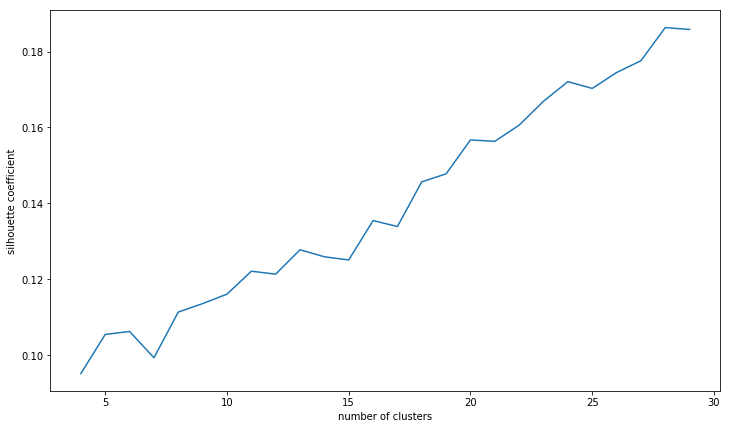

In [86]:
# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10), sharex=True, dpi=80)
# k_clusters = range(4,30)
# ax1.plot(k_clusters, Sil_coefs)
# ax1.set_xlabel('number of clusters')
# ax1.set_ylabel('silhouette coefficient')

# # plot here on ax2
# ax2.plot(k_clusters, SSEs)
# ax2.set_xlabel('number of clusters')
# ax2.set_ylabel('SSE');

k_clusters = range(4,30)
plt.figure(figsize=(12,7))
plt.plot(k_clusters, Sil_coefs)
plt.xlabel('number of clusters')
plt.ylabel('silhouette coefficient')

In [132]:
# Create KMeans
kmeans = KMeans(n_clusters=18)

# Cluster
ng_lsi_clusters = kmeans.fit_predict(norm_ng_lsi)

In [221]:
cluster_0 = np.array(article_text[ng_lsi_clusters == 0])
cluster_1 = np.array(article_text[ng_lsi_clusters == 1])
cluster_2 = np.array(article_text[ng_lsi_clusters == 2])
cluster_3 = np.array(article_text[ng_lsi_clusters == 3])
cluster_4 = np.array(article_text[ng_lsi_clusters == 4])
cluster_5 = np.array(article_text[ng_lsi_clusters == 5])
cluster_6 = np.array(article_text[ng_lsi_clusters == 6])
cluster_7 = np.array(article_text[ng_lsi_clusters == 7])
cluster_8 = np.array(article_text[ng_lsi_clusters == 8])
cluster_9 = np.array(article_text[ng_lsi_clusters == 9])
cluster_10 = np.array(article_text[ng_lsi_clusters == 10])
cluster_11 = np.array(article_text[ng_lsi_clusters == 11])
cluster_12 = np.array(article_text[ng_lsi_clusters == 12])
cluster_13 = np.array(article_text[ng_lsi_clusters == 13])
cluster_14 = np.array(article_text[ng_lsi_clusters == 14])
cluster_15 = np.array(article_text[ng_lsi_clusters == 15])
cluster_16 = np.array(article_text[ng_lsi_clusters == 16])
cluster_17 = np.array(article_text[ng_lsi_clusters == 17])

In [151]:
def get_clusters_for_year(yr):
    articles_for_year = raw_df[raw_df['year'] == yr]['article']
    # fit articles for year to tfidf
    print('retrieved articles for {}'.format(yr))
    tfidf_vecs_yr = tfidf.transform(articles_for_year)
    print('done transforming to TFIDF')
    # convert to corpus
    tfidf_corpus_yr = matutils.Sparse2Corpus(tfidf_vecs_yr.transpose())
    print('Transformed to corpus')
    # reduce features with trained LSI
    lsi_corpus_yr = lsi[tfidf_corpus_yr]
    print('reduced features')
    # convert from gensim format to numpy array
    ng_lsi_yr = matutils.corpus2dense(lsi_corpus_yr, num_terms=50).transpose()
    print('convert back to numpy array for kmeans')
    # normalize it for kmeans
    norm_ng_lsi_yr = normalize(ng_lsi_yr)
    print('normalized')
    # predict
    print('predicting...')
    ng_lsi_clusters_yr = kmeans.predict(norm_ng_lsi_yr)
    return ng_lsi_clusters_yr

In [165]:
def get_breakdown(cluster):
    unique, counts = np.unique(cluster, return_counts=True)
    return counts

In [167]:
yearly_count_breakdowns = []
for yr in range(2011, 2018):
    print('year: {}'.format(yr))
    yearly_count_breakdowns.append(get_breakdown(get_clusters_for_year(yr)))

year: 2011
retrieved articles for 2011
done transforming to TFIDF
Transformed to corpus
reduced features
convert back to numpy array for kmeans
normalized
predicting...
[1031 1558 1262 2815 1202 1371 1646 1922 3344 2053 3019 1950 2537 3855
  995 1834 1623 2086]
year: 2012
retrieved articles for 2012
done transforming to TFIDF
Transformed to corpus
reduced features
convert back to numpy array for kmeans
normalized
predicting...
[ 890 1466 1318 3442 1505 1373 1629 2054 3540 2007 2729 1925 2000 3830
 1019 1809 1512 2009]
year: 2013
retrieved articles for 2013
done transforming to TFIDF
Transformed to corpus
reduced features
convert back to numpy array for kmeans
normalized
predicting...
[ 785 1237 1259 2811 1256 1395 1801 1998 3491 2008 2277 1861 2185 3909
  963 1821 1600 2138]
year: 2014
retrieved articles for 2014
done transforming to TFIDF
Transformed to corpus
reduced features
convert back to numpy array for kmeans
normalized
predicting...
[ 949 1632 1548 3292 1235 1233 2129 2526 4314